# Toxic comments

This notebook takes you though a complete iteration of Machine Learning Assignment 1 - Toxic comments. The assignment details (including links to download the data) can be found [here](https://docs.google.com/document/d/1WGYw99e5q6j5V0Zrf2HveagU6URt_kVvdR8B9HYQ99E/edit?usp=sharing). 

In [1]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

### IMPORTANT!!! Make sure you are using `BinaryClassificationPerformance` v1.02

In [2]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

# Function for feature building and extraction on natural language data

In [3]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    toxic_data = pd.read_csv(fn)
    if (not test):
        # add an indicator for any toxic, severe toxic, obscene, threat, insult, or indentity hate
        toxic_data['any_toxic'] = (toxic_data['toxic'] + toxic_data['severe_toxic'] + toxic_data['obscene'] + toxic_data['threat'] + toxic_data['insult'] + toxic_data['identity_hate'] > 0)
    print("toxic_data is:", type(toxic_data))
    print("toxic_data has", toxic_data.shape[0], "rows and", toxic_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in toxic_data:")
    print(toxic_data.dtypes, "\n")
    print("the first 10 rows in toxic_data:")
    print(toxic_data.head(5))
    if (not test):
        print("The rate of 'toxic' Wikipedia comments in the dataset: ")
        print(toxic_data['any_toxic'].mean())

    # vectorize Bag of Words from review text; as sparse matrix
    if (not test): # fit_transform()
        hv = HashingVectorizer( n_features=2 ** 15, alternate_sign=False, strip_accents='ascii', lowercase=True, ngram_range=(1,3))
        
        
        
        ## 3 changes. strip accents, lowercase, ngram_range,  ## 
        
        #CUT FROM ORIGINAL: 
        #n_features=2 ** 17, 
        ## n_features=2 ** 16
        ### ngram_range(1,3)
        
        X_hv = hv.fit_transform(toxic_data.comment_text)
        fitted_transformations.append(hv)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    else: # transform() 
        X_hv = fitted_transformations[0].transform(toxic_data.comment_text)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    if (not test):
        transformer = TfidfTransformer()
        X_tfidf = transformer.fit_transform(X_hv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[1].transform(X_hv)
    
    # create additional quantitative features
   
    toxic_data['word_count'] = toxic_data['comment_text'].str.split(' ').str.len()
    toxic_data['punc_count'] = toxic_data['comment_text'].str.count("\.")
   # toxic_data['case_count'] = toxic_data['comment_text'].str.split(' ').str.isupper()
    toxic_data['punc_count2'] = toxic_data['comment_text'].str.count("\!")
    ####new columns here 
    toxic_data['upper_case'] = toxic_data['comment_text'].str.count(r'[A-Z]')
    
    

    X_quant_features = toxic_data[["word_count", "punc_count", "punc_count2", "upper_case"]]
    
    #####
    
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    if (not test):
        sc = StandardScaler(with_mean=False)
        X = sc.fit_transform(X_matrix)
        fitted_transformations.append(sc)
        print(X.shape)
        y = toxic_data['any_toxic']
    else:
        X = fitted_transformations[2].transform(X_matrix)
        print(X.shape)
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(toxic_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, toxic_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

# Create training and test sets from function

In [4]:
# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations = []

# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='C:/Users/Dallas/Desktop/Machine Learning/toxiccomments_train.csv', my_random_seed=85)

print("Number of fits stored in `fitted_transformations` list: ")
print(len(fitted_transformations))

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 159571 rows and 9 columns 

the data types for each of the columns in toxic_data:
id               object
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
any_toxic          bool
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  any_toxic  
0             0        0     

# Fit (and tune) Various Models

### MODEL: ordinary least squares

In [5]:
from sklearn import linear_model
ols = linear_model.SGDClassifier(loss="squared_loss")
ols.fit(X_train, y_train)

ols_performance_train = BinaryClassificationPerformance(ols.predict(X_train), y_train, 'ols_train')
ols_performance_train.compute_measures()
print(ols_performance_train.performance_measures)

{'Pos': 12979, 'Neg': 114677, 'TP': 6257, 'TN': 57278, 'FP': 57399, 'FN': 6722, 'Accuracy': 0.4977047690668672, 'Precision': 0.09829395500816891, 'Recall': 0.48208644733800754, 'desc': 'ols_train'}


C:\Users\Dallas\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


### MODEL: SVM, linear

In [6]:
from sklearn import linear_model
svm = linear_model.SGDClassifier()
svm.fit(X_train, y_train)

svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
svm_performance_train.compute_measures()
print(svm_performance_train.performance_measures)

{'Pos': 12979, 'Neg': 114677, 'TP': 12956, 'TN': 114624, 'FP': 53, 'FN': 23, 'Accuracy': 0.9994046499968666, 'Precision': 0.9959258974556077, 'Recall': 0.9982279066183836, 'desc': 'svm_train'}


In [7]:
### MODEL: SVM, linearSVC

In [8]:
# class sklearn.svm.LinearSVC(penalty='l2', loss='squared_hinge', *, dual=True, tol=0.0001, 
#C=1.0, multi_class='ovr', fit_intercept=True, 
#intercept_scaling=1, class_weight=None, verbose=0, random_state=None, max_iter=1000)

from sklearn.svm import LinearSVC
svc = LinearSVC(C=.0001, max_iter=100000)
svc.fit(X_train, y_train)
svc_performance_train = BinaryClassificationPerformance(svc.predict(X_train), y_train, 'svc_train-c=.0001')
svc_performance_train.compute_measures()
print(svc_performance_train.performance_measures)

{'Pos': 12979, 'Neg': 114677, 'TP': 12485, 'TN': 114611, 'FP': 66, 'FN': 494, 'Accuracy': 0.9956132105032274, 'Precision': 0.9947414548641542, 'Recall': 0.9619385160644117, 'desc': 'svc_train-c=.0001'}


### MODEL: logistic regression

In [9]:
from sklearn import linear_model
lgs = linear_model.SGDClassifier(loss='log')
lgs.fit(X_train, y_train)

lgs_performance_train = BinaryClassificationPerformance(lgs.predict(X_train), y_train, 'lgs_train')
lgs_performance_train.compute_measures()
print(lgs_performance_train.performance_measures)

{'Pos': 12979, 'Neg': 114677, 'TP': 12956, 'TN': 114662, 'FP': 15, 'FN': 23, 'Accuracy': 0.9997023249984333, 'Precision': 0.9988435741268985, 'Recall': 0.9982279066183836, 'desc': 'lgs_train'}


### MODEL: Naive Bayes

In [10]:
from sklearn.naive_bayes import MultinomialNB
nbs = MultinomialNB()
nbs.fit(X_train, y_train)

nbs_performance_train = BinaryClassificationPerformance(nbs.predict(X_train), y_train, 'nbs_train')
nbs_performance_train.compute_measures()
print(nbs_performance_train.performance_measures)

{'Pos': 12979, 'Neg': 114677, 'TP': 11503, 'TN': 102921, 'FP': 11756, 'FN': 1476, 'Accuracy': 0.8963464310334023, 'Precision': 0.49456124510942, 'Recall': 0.8862778334232221, 'desc': 'nbs_train'}


### MODEL: Perceptron

In [11]:
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron')
prc.fit(X_train, y_train)

prc_performance_train = BinaryClassificationPerformance(prc.predict(X_train), y_train, 'prc_train')
prc_performance_train.compute_measures()
print(prc_performance_train.performance_measures)

{'Pos': 12979, 'Neg': 114677, 'TP': 12947, 'TN': 114647, 'FP': 30, 'FN': 32, 'Accuracy': 0.9995143197342858, 'Precision': 0.9976882176157817, 'Recall': 0.9975344787734032, 'desc': 'prc_train'}


### MODEL: Ridge Regression Classifier

In [12]:
from sklearn import linear_model
rdg = linear_model.RidgeClassifier(5)
rdg.fit(X_train, y_train)

rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg_train')
rdg_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

{'Pos': 12979, 'Neg': 114677, 'TP': 9493, 'TN': 114515, 'FP': 162, 'FN': 3486, 'Accuracy': 0.9714231998495958, 'Precision': 0.9832211289487313, 'Recall': 0.7314122813776099, 'desc': 'rdg_train'}


### MODEL: Random Forest Classifier

In [13]:
from sklearn.ensemble import RandomForestClassifier
rdf = RandomForestClassifier(max_depth=2, random_state=0)
rdf.fit(X_train, y_train)

rdf_performance_train = BinaryClassificationPerformance(rdf.predict(X_train), y_train, 'rdf_train')
rdf_performance_train.compute_measures()
print(rdf_performance_train.performance_measures)

{'Pos': 12979, 'Neg': 114677, 'TP': 0, 'TN': 114677, 'FP': 0, 'FN': 12979, 'Accuracy': 0.8983283198596227, 'Precision': nan, 'Recall': 0.0, 'desc': 'rdf_train'}


C:\Users\Dallas\Desktop\Machine Learning\final_assignment_1\my_measures.py:25: RuntimeWarning: invalid value encountered in longlong_scalars
  self.performance_measures['Precision'] = self.performance_measures['TP'] / (self.performance_measures['TP'] + self.performance_measures['FP'])


### ROC plot to compare performance of various models and fits

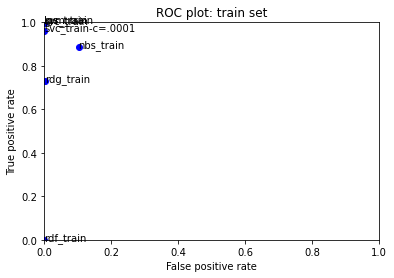

In [14]:
fits = [svc_performance_train, svm_performance_train, lgs_performance_train, nbs_performance_train, prc_performance_train, rdg_performance_train, rdf_performance_train]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: train set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

### looking at reviews based on their classification

Let's say we decide that Ordinary Least Squares (OLS) Regression is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well. 

### let's look at some false positives:

In [15]:
ols_predictions = ols.predict(X_train)

In [16]:
# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(ols_predictions)):
    if (ols_predictions[i] == 1):
        if (X_raw_train.iloc[i]['any_toxic'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['comment_text'])
                print('* * * * * * * * * ')


Examples of false positives:
0
Turkey isn't invading Syria anytime soon, also its a motto, Frances motto has equality when there is religious restriction on headscarves. Their motto is still up
* * * * * * * * * 
26
"::::""Sneer""?  That's not NPOV!!!  (talk) 

"
* * * * * * * * * 
110
"

Speedy deletion of Music Singularity
 A tag has been placed on Music Singularity requesting that it be speedily deleted from Wikipedia. This has been done under section A7 of the criteria for speedy deletion, because the article appears to be about web content, but it does not indicate how or why the subject is notable: that is, why an article about that subject should be included in an encyclopedia. Under the criteria for speedy deletion, articles that do not indicate the subject's importance or significance may be deleted at any time. Please see the guidelines for what is generally accepted as notable, as well as our subject-specific notability guideline for web content. 

If you think that this not

2034
Conspiracy/Complicity
Hi, I just posted a message here: Talk:9/11_domestic_conspiracy_theory where I point out that a tiny handful of folks are bouncing from page to page renaming pages and asking for votes on titles as a way to circumvent an ongoing discussion that has been going on for months. Is there a way to facilitate a discussion on one special page to try to resolve the title question that will affect many pages? The details are on the linked page. Thanks for all your hard work.
* * * * * * * * * 
2039
That's helpful.  Thanks. My focus has been on the first half of the article - I will work on the rest.
* * * * * * * * * 
2146
Radical Departure From traditional banking practices 

This article doesn't convey the sense that Check 21 is a radical departure from the way banks have traditionally worked.  The cancelled check was a key part of traditional checking.  The cancelled check is proof that a drawer has payed pursuant to the terms of the check.  Not only do you have pro

3997
I have removed the offending adjective and verb.
* * * * * * * * * 
4027
Note
All below visible warnings are posted by a person who is obviously mentally challenged. Therefore, this talk page is of no use to me. Any discussion related to any of my edits will be honored only on the pages where it happens to be commited.
* * * * * * * * * 
4035
It doesn't matter if YOU think the information is not constructive to your view points, unless you've done the research or played the game first hand then you have no comment to make. So stop. This is a war you won't win.
* * * * * * * * * 
4075
If someone who posted the keys or a link to the keys sent a DMCA counter-notice to the Foundation, the Foundation would then inform TI, and TI would then either choose to take the counter-notice filer to court to settle the issue or they would drop the claim, in which case the Foundation would be legally required to restore the deleted information. IANAL.
* * * * * * * * * 
4090
All it says at the Man

6075
"

Found something already- Livingstone claiming Holyroyd & Wallace were both in Clockwork Orange here in an Independent article from 21 May 1999.

""My allegations were that a small group of MI5 and MI6 officers conspired to wreck the cease-fire negotiated between the Labour government and the IRA in February 1975""

""In the years that followed, I submitted more than 300 questions about the ""dirty"" war in Ireland and after years of denial, 'the government was forced to admit that the intelligence services had engaged in a covert black propaganda campaign, code-named Clockwork Orange'.""

""Colin Wallace, a former Army intelligence officer who had been one of my two key sources of information, was found to have been framed for manslaughter and was eventually compensated.   'My second source', Captain Fred Holroyd, who worked for MI6, was discredited by being committed to a psychiatric hospital and has never received the compensation that is his due.""

""The spymaster Peter Wri

8327
I'm moving this to the talk page.
* * * * * * * * * 
8383
I think that a criticism section is probably unwarranted in this Wikipedia article, for the simple fact that if you want to read about criticism of Ctrl Alt Del, you can visit umpteen other websites on the internet that complain at length about how much they hate Ctrl Alt Del. Most of us know the main criticisms made at CAD in any event (templated, unfunny, rip-off of other webcomics, bad pacing, insipid storylines, etc etc). But just because other people have that opinion of CAD doesn't necessarily make it necessary to include a criticism section. I mean, I think Limp Bizkit suck. I also think CAD sucks, if I'm being honest. But rather than force my opinion on others, I just don't listen to Limp Bizkit, and I don't read CAD. Problem solved. 58.108.241.214
* * * * * * * * * 
8390
I agree a nice job with the article. I added a notable people section to the Ollie, Iowa article and listed Polly Rosenbaum in it. I have a love/h

10467
you're not going to get away with this
* * * * * * * * * 
10482
For the last damm time i'm not Sean800 -
* * * * * * * * * 
10494
"

 Re: Notice at the top 

Take it easy, mate.  (T+C+CVU) "
* * * * * * * * * 
10644
"

That permission is not valid.

We need to see permission from the copyright holder - whoever owns the copyright.

The fact that other websites/google use it does not help.

We need firm 'proof' that it is released into the public domain.

See Wikipedia:Finding images tutorial#Do I need to know the copyright and licensing status of the image?.  ►  "
* * * * * * * * * 
10703
Married Women's Property Act 1882

Probably some of that info should be added to Coverture instead...
* * * * * * * * * 
10724
Stop templating my Talk page 

If you are not going to discuss, stay off my Talk page.  Is that clear?  After another editor harassed me like you are with gratuitous templating I took it to an admin noticeboard and that put a stop to it.  Is that what's necessary here?  I

12693
JRJ's Birthplace 

I have been trying to correct the birthplace and birthyear of JRJ and someone keeps changing it back, claiming he was born in Wigtown. As I have a copy of his birth certificate (which confirms he was born in Lee in 1907) I would ask them to leave it be. Many thanks.
* * * * * * * * * 
12756
Thanks again, just need to try and establish notability now. Does their bands featuring in major magazines, appearing in support of notable bands count as notability? Or would I have to create the individual band pages first?
* * * * * * * * * 
12867
Hi  Thank your mery much for your reply, and particularly for taking so much time to argue and to check the Unregistred Wikipedian's edits, and you are completely right -) Just btw and 'notice-to-myself': bad by me to mention just IP (don't appreciate that term, but to hurried). As hopefully implied, i did not intend to allege some unfaithfull edits, to you 75.147.51.1, and therefore, also no offense. Was just confused, short in

14670
Muslim 

Was he a recent Islamic convert?
* * * * * * * * * 
14712
":Well, of course, since it's a piece of ficticious crap, the answer is nobody. On a more serious note, designs can be patented, texts and images can be copyrighted, but ideas and concepts cannot be owned. Once sombody came up with the idea of creating conductors for electricity (e.g., wires), they could copyright the design of a machine for making wire, but couldn't claim ownership of the entire concept of a conductor made of a strand of metal. the book seems to take the position that this is wrong. The ""motor"" couldn't be owned by anybody if it simply relied on physical properties that a certain design took advantage of. This is one of the major failings of the novel, IMO: it relies on a fantasy of perpetual motion.    

"
* * * * * * * * * 
14763
Facts have contradicted me and Brock is quoted in the NYT regarding a 4 million dollar war chest. Go ahead and make your preferred edits.
* * * * * * * * * 
14773
Ed

16695
(which were for the exact same reasons)
* * * * * * * * * 
16715
Pop/Rock is sourced. Sourced, relevant material is what the encyclopedia is based on. I don't see what's hard to understand about that. If polka was sourced we could add that. The basis of Wikipedia is not truth. It's verifiability. Simply disagreeing with something on a basis of whether or not it's true is irrelevant.
* * * * * * * * * 
16718
Uhm.. This IP is blocked, interesting.
* * * * * * * * * 
16791
Get up, get get, get down
* * * * * * * * * 
16878
My lack of response was due to business.  As for that revert, I completely agree with your edit and do not know why
* * * * * * * * * 
16912
"

 ""African American TRIBES""???? 

The article currently includes this: ""In populations with high rates of carriage (Ashkenazi Jews and Norrbottnian Swedes and a few African American tribes)...""

What could posibly be meant by ""African American tribes""? I'm an American. We have no tribes here, African or otherwise."
* 

* * * * * * * * * 
18708
Are you claiming that the text is promotion? Would you please stop making changes without explaining yourself? That is not how we do things on Wikipedia normally. Editors should note why they are making changes so that other editors do not consieder it unwarranted vandalism.
* * * * * * * * * 
18946
":It doesn't even seem that an amendment is subject to the P-5 vote, but that all of the ""Permanent Five"" must agree to an amendment. Yes, that seems to be an entrenched clause. What is strange is that many of the Members do not adhere to the UN Universal Declaration of Human Rights, but can still be Members.  

"
* * * * * * * * * 
18954
accepting stuff
I accept. 205.250.212.226
* * * * * * * * * 
19054
Moved to People In Hell Now, Notable.
* * * * * * * * * 
19071
White men marches on 

Why have you deleted this article? I know it's a racist song but it quite famous song sang for white supramecist groups. I think that the song is enough important to be on wikipe

20743
WP:LOTD 

As a nominator, you may want to vote before voting ends as soon as I get to it after the end of the day on the 20th. (t/c//WP:CHICAGO/WP:LOTD)
* * * * * * * * * 
20812
Alaeddin Keykubad 
Hi Angus! Do you think it would be a good idea to open a new proposal for the articles on the three Seljuk sultans named Alaeddin Keykubad to be titled under their correct form? You had brought in your interventions in a macro-cosmical manner during the last two caucuses, which is why I am seeking your opinion before else. If you check Alanya article on wikipedia main page today, you will see that the name is rendered as Alaeddin Keykubad for the first and foremost one. To add an opinionated note, I am expecting little initiative from my fellow Turks on putting the name of an old sultan in correct form, ruminating cattle as many are. All at the same time as holding rather heterodox stances, it had fallen on me to defend the article on the mosque too. Anyway, I can arrested for writing s

22811
Look at the history -)  12:10, 16 Dec 2004 (UTC)
* * * * * * * * * 
22855
Mr.crabs lives in bikini bottom
* * * * * * * * * 
22868
Hi Compman, thanks for contributing to wikipedia but I don't think we can accept materials copied directly from Canadian government webisites, so I'll have to tag some of your contributions as copyvio. Please let me know if I am wrong.
* * * * * * * * * 
22963
Hey, okay! no harm was done! cheers,
* * * * * * * * * 
22971
By the way, I like the work you're doing on Crayola stuff. I think there's a very strong argument for Crayola crayons not to be a redirect.
* * * * * * * * * 
23069
"

I have indefinitely blocked you for repeated violations of any number of Wikipedia policies over many months and many blocking admins.  You show no signs of trying to improve, and even when given your final warning, just above, you responded with more of the same.  I haven't really been involved with you before and just kind of ran across this and realized, do what is g

25059
point taken, will replace 'rooting out' with 'terminate' Thanks
* * * * * * * * * 
25101
"

On 19:57, 12 August 2012‎ you (86.150.65.44) made an edit with the edit title ""Revert unauthorised change to my comment by Wtshymanski""

Seven minutes later, on 20:04, 12 August 2012 you posted the above warning.

Diff for your revert

Your change consisted of changing a link. Wtshymanski had it as  

Request for Comment

and your revert changed it to

Request for Comment Request

(Is that related to the Department of Redundancy Department?)

Your full paragraph: ""It was not a personal attack but a statement of undisputed fact (and was not even disputed by you at the recent Request for Comment Request, whose outcome you still continue to ignore. The above two points underline the point admirably.""

Your link goes to an RfC that was closed on  with an outcome of

""no immediate administrative action appears required. However, I invite Wtshymanski to take the concerns voiced here under s

27062
Is this in jest or a joke? 

What do you mean with this: “dangerous”? Of course I can (may) talk to anyone I chose in real life. I’ve run my edits by cited Ph.D.s to make sure the material I write is correct and factual and correctly paraphrases what they mean. And everything is properly cited. Is there something wrong with that?
* * * * * * * * * 
27146
I really like your picture of Saguaro National Park.  Was that taken with a polarized lense?
* * * * * * * * * 
27148
I agree.  I'd do it if I could work out how...
* * * * * * * * * 
27172
Nazi and different eyes 
My friend told me that he was a Nazi and he said that Hitler was a great man. He also told me that the reason for his different colours in his eye is because of a fight he got into when he was teen. Are those thing true or rumors that he heared?
* * * * * * * * * 
27212
68.191.214.247  }},

I have not made any personal attacks whatsoever. This ban is completely unwarranted and is in the form of persecution, because I d

29189
"

 missing reference regarding to songs written about him 

the boulder, colorado music group ""warlock pinchers"" wrote and performed a song called 'where the hell is crispin glover?'"
* * * * * * * * * 
29194
Sounds like a violation of WP:SOCK to me.  Unblock declined.  —   }}
* * * * * * * * * 
29351
them at the end by typing
* * * * * * * * * 
29353
Doesn't really sound like a performance issue then. —
* * * * * * * * * 
29399
"

 The Tireless Contributor Barnstar 

  The Tireless Contributor Barnstar I'm awarding you this barnstar for your great work on Wikipedia!  (talk) "
* * * * * * * * * 
29415
I agree with keeping a brief 1-2 sentence description for the private servers because the projects seem to have become popular within the Toontown Online community. However it should be made clear that these projects have no affiliation with The Walt Disney Company, they have no permission to remake Toontown Online, and they are entirely community servers made by players of the g

31259
"::::Anyone can declare anything, but that has no affect on reality unless it is put into practice. What's more, ""the separatists"" do not agree as to whether they've declared it or not, and even proponents of the Novorossiya idea say that it does not exist in practice.  — ☎ 
"
* * * * * * * * * 
31279
Deskana, i started to question what are the criterias for vandalism, should Alexius come to my home and break my computer, would that be considered vandalism? He deleted a number of time my properly sourced quotations and citations..
* * * * * * * * * 
31346
"==Sockpuppetry case==
 
You have been accused of sockpuppetry. Please refer to Wikipedia:Suspected sock puppets/TomPhan for evidence. Please make sure you make yourself familiar with notes for the suspect before editing the evidence page.  talk "
* * * * * * * * * 
31370
"

 I have already given sources and facts, you have not. I will continue to re=post on a regualr basis to undo your hack edits. 

I have provided sources. I

33451
Note the control he believes he has over you. Like any IRA man, he believes that others will bow to his tactics of intimidation and fear. I believe that quite literally our lives are in danger until and unless he is expelled from Wikipedia.
* * * * * * * * * 
33519
"Thanks for experimenting with the page T-Bone Walker on Wikipedia. Your test worked, and has been reverted or removed. Please use the sandbox for any other tests you want to do. Take a look at the welcome page if you would like to learn more about contributing to our encyclopedia.  Thanks.    說嗎? "
* * * * * * * * * 
33528
I had a look over it now (I couldn't earlier, collateral IP ban from being on a shared server) and it only needed very small changes for it to flow
* * * * * * * * * 
33588
Recipients of the Lithuanian National Prize
Hi, thanks for your copy-editing on Lithuanian Science Society!

Speaking about Recipients of the Lithuanian National Prize i think it would be great to expand and crate some articles a

35450
"
The Google search for Pediatric reads ""The Encyclopedia anyone can edit"" NOT ""The Encyclopedia on registered users can edit"".  There is a BIG difference between the two."
* * * * * * * * * 
35495
Welcome...

Hello, Hawthornewipes2009, and welcome to Wikipedia! Thank you for your contributions. I hope you like this place and decide to stay.  Here are some  pages that you might find helpful:
Introduction
The five pillars of Wikipedia
How to edit a page
Help
How to write a great article
Manual of Style

Please sign your name on talk pages using four tildes (~~~~); this will automatically produce your username and the date. If you need help, check out Wikipedia:Questions, ask me on my talk page, or place {{helpme}} on your talk page and ask your question there.   Again, welcome!
* * * * * * * * * 
35535
Thank you for experimenting with the page Ipsos on Wikipedia. Your test worked, and has been reverted or removed. Please use the sandbox for any other tests you want to do. Take

37677
GTR 

Should GTR lister as a supergroup? Formed by Steve Hower and Steve Hackett.
* * * * * * * * * 
37865
"

Copyright
Copyright is a tricky issue, and I am still struggling with it. In this case, the photographer is the copyright owner rather than Day and even Day's permission may not be good enough. If you know the name of the photographer, it's probably OK if you credit him in the caption - have a look at  for a similar one I uploaded. Meanwhile, this page gives some possibilities for usable copyright tags: Wikipedia:Image_copyright_tags/Displayed_and_ranked. Hope that helps, but it is a minefield. '''''' (talk - contribs) "
* * * * * * * * * 
37998
"::The map has been here for years without anyone disputing it. What parts specificly do you think are incorrect? You can add  tags if you want. khoi 

"
* * * * * * * * * 
38192
Hii 

It seems that we are both being picked on by other editors- what are you interested in editing?
* * * * * * * * * 
38219
The idea that this planet 

40047
Discovery 

Shouldn't there be a section on how and when humans discovered that there are different blood types?
* * * * * * * * * 
40062
I think this should be merged with the article 'Port-Salut cheese', since they describe exactly the same cheese.
* * * * * * * * * 
40294
Not one of these books speaks to seeing God (theoria) in the context of Orthodox theology, as the seeing of the uncreated light. Not one. At best they warm over the Greek philosophy use of the term making theoria as part of scholasticism and scholastic systematic theology. Not one of these sources is even Greek themselves. As such how does Augustine and the Roman Catholic use not equate to undue weight? LoveMonkey
* * * * * * * * * 
40328
]] (talk • contribs) 01:20, June 29, 2007
* * * * * * * * * 
40374
"
This is Wikipedia. Anyway, OR is just a rule of thumb, often a very flawed one. I'll take the weight of evidence in regard to past behavior instead. "
* * * * * * * * * 
40471
this is what is wrong with wik

42171
Thanks for finding my error.  I'm not sure I would have wiped it clean myself.  Anyway, someone had created an article about him back in September 2001 soon after the 9-11 mess, so it's now be re-added back to that article.
* * * * * * * * * 
42179
"

 OnePure 
Hi Velella,
OnePure is being considered for deletion and got attached the relevant tag (""...Article for deletion/dated|page=OnePure|timestamp=20131220174859|year=2013|month=December|day=20|substed=yes|help=off"") yesterday with your comment ""Notability appears to centre on the products being Halal. However all refs appear to be press releases and interviews from such press releases. No refs of any substance and independence. This looks like simple advertising."". Now that i have replaced all the references from press releases and all those references that were raising the flag of advertisement and publicity with a few solid references of third party coverage, i request you to kindly go through the article again and see i

44249
"Hello, , and welcome to Wikipedia! Thank you for your contributions. I hope you like the place and decide to stay. Here are some pages that you might find helpful:

    Introduction
  5    The five pillars of Wikipedia
    How to edit a page
    Help
    Tips
    How to write a great article
    Simplified Manual of Style
    Fun stuff...

I hope you enjoy editing here and being a Wikipedian! Please sign your name on talk pages using four tildes (~~~~); this will automatically produce your name and the date. If you need help, check out Wikipedia:Questions, ask me on my talk page, or place {{helpme}} on your talk page and someone will show up shortly to answer your questions. Again, welcome!    (reasoning) "
* * * * * * * * * 
44327
I am sick of you saying I am a vandal.
* * * * * * * * * 
44358
"
If they are notable, find a source that says that they are notable. These list of favorite players should be removed from this page, as well as from the other position articles. Dil 

W

* * * * * * * * * 
46292
"

 I agree. I have had a small amount of time this evening to do a little research. This 2010 review  could perhaps help in bridging the void. It states that there is a ""lack of consensus"" and ""robust evidence"" within the medical literature for things such as penile cancer, STI and UTI, while maintaining there is evidence for HIV prevention (at least in the African trials). If I had the time I would be tempted to run a statistical analysis on the medical reviews themselves! I suspect there would be a clear correlation betweeen the conclusions reached and the country from which they originated. Which brings us (in my opinion) to the crux of the matter. Rightly or wrongly, this is primarily a ritualistic or cosmetic procedure, regardless of what evidence or opinion the medical community has, or will provide. Therefore, to treat this as almost an entirely statistically based article, while only giving a cursory nod to the ethical debate, just feels wrong to m

48277
List of programs 

It is not fair that you had to delete the list of all programs that have been issued by the channel, if that's very important, because without that list, you would have no idea what they broadcast on the channel, because then the information would be confusing and meaningless, and it is important to clarify what kind of programs are currently issued or issued in the Latin American version of the channel has to be done halgo, it's not fair! 181.140.167.24
* * * * * * * * * 
48305
Wait a minute 

Wait a minute...
I thought the first film was released in 1896. And the oldest film was released in 1888. Something seems to be wrong. When was the first film released? Comon people, lets get our facts straight.
* * * * * * * * * 
48360
http://www.100welshheroes.com/en/biography/roalddahl
go argue your anti welsh points with them
* * * * * * * * * 
48384
" October 2008 (UTC)

DavidRuben hasn't been involved in any of the recent content disputes in the CFS pages, as far a

50420
"
Thanks Love! We've got some really good reviews so far from a couple of other guys, but all the eyes that are cast upon the article at PR make its chance of passing FAC so much better. Thanks heaps! vu "
* * * * * * * * * 
50431
"Please cease your misuse of sources regarding homeopathy. In this edit, you claimed that the Swiss Medical Weekly endorses homeopathy. However, that report actually reviews a separate report that endorsed homeopathy, and concluded that the other report ""is scientifically, logically and ethically flawed"". The Swiss Medical Weekly also added that the other report ""proves that homeopaths are willing to distort evidence in order to support their beliefs"". It appears that you are just as willing to misrepresent sources in favour of homeopathy.  

"
* * * * * * * * * 
50461
The article is certainly much better for your edits.  Good luck with your project of encouraging good contributions.
* * * * * * * * * 
50464
"

Transclusion Limit this is what the rp

52712
I can't speak for Jimbo, but if I were in his position I would consider it an obligation to enforce the integrity of wikipedia in extreme cases like this, in spite of any disproportionate controversy that may possibly result from my actions. This seemed like a clear cut case of administrator abuse to me (I'm a centrist; no bias accusations please). Most of the small handful of people who know about this controversy will forget about it within a week or month. The article, on the other hand, would be lost forever; the knowledge therein stolen from innumerable potential readers. Think of the bigger picture, and moreover, consider these overreactions and what they implicate.
* * * * * * * * * 
52726
Yep, David section shall be reviewed, prolly when I wake tomorrow. Thanks,  (Talk)
* * * * * * * * * 
52750
(than about other matrilineal kinships)
* * * * * * * * * 
52767
Redirecting pages 

Although pages which contain no information but an internal link ('See [link]) can be useful, W

55012
Also, please do not add non-existent categories to articles. If you don't understand our category system, you best leave it alone.
* * * * * * * * * 
55067
Page numbers are always good to give so that people can find the information without having to read the whole book.
* * * * * * * * * 
55082
REDIRECT Talk:La Jolla, San Diego/archive 1
* * * * * * * * * 
55142
you, thinking that you're selling, while you're buying.

 The Crash  Interview with Jeff Sachs  PBS Frontline  Spring, '99
 Through 1997, this Ponzi scheme and the addiction to debt is building. Then the Asian crisis starts in the middle of '97. How does that affect
* * * * * * * * * 
55150
"
As for the Inoki title reign I am not familiar with all of the facts to give a sound opinion on whether it is official or not.C "
* * * * * * * * * 
55166
"

Hello, Tgeorgescu... It was correct what you added, sourced, and valid what you put in, according to context, and according to WP due and undue and sources.  Your edit and addi

57247
Please see the bootom of the page for my unblock request**
* * * * * * * * * 
57276
Here's an idea for you!!! 

Try looking at the bloody articles before reverting them.
99.238.74.216
* * * * * * * * * 
57352
What a crappy rule. just there to make people get their own way, cannot go against a project 194.66.216.40
* * * * * * * * * 
57407
"

 Some baklava for you! 

  i love takis and hot cheetos   "
* * * * * * * * * 
57431
Your mouth says stop but your eyes say keep goooing!
* * * * * * * * * 
57474
Flyer, I just want you to know I'm sorry for all the disruption I caused. However, the other IP addresses are not me, I'm serious. They're probably just some editor who I've pissed off and is now trying to get me blocked forever by making it seem like I'm still being disruptive.
* * * * * * * * * 
57544
What do you think, now? This looks very close to me. Maybe we could try another PR, or go straight to FA. I think the article is now very strong - even more so than back in mid-Decem

59199
you can help in the creationg
* * * * * * * * * 
59219
Your lack of concern about others while imposing your will upon them reminds me of this:
* * * * * * * * * 
59252
Count me in on this.  I've  been helping out as much as i could with FF articals.  I'll be glad to help out some more, especially if a project starts up.  6 July 2005 01:54 (UTC)
* * * * * * * * * 
59325
Reversion of East India Company link 

The edit that I made here with the about.com website link does follow the guidelines for external links.
* * * * * * * * * 
59394
Comment 

If its not too churlish, I think there should be a few lines in about the only meaningful attacks made in daylight against the landings by the Luftwaffe. No substantial by any means, but it keeps the myth that the only German aircraft to appear over the beaches were the Fw 190s of Priller and his wingman.
* * * * * * * * * 
59412
. I shall spend the next week or two writing an article on paper before uploading it here
* * * * * * * * * 
5

61358
October 2009 (UTC)
Here's another one: First Baptist Church (Montgomery, Alabama). Tide, I got a job for you: drive around and take pictures. Look at the historical markers (and take a picture, to remind yourself later of what was there). Then start writing them up! We got a lot of white space on our map. Take it easy,   04:24, 31
* * * * * * * * * 
61505
(UTC)

I am unsure about thefactual accuracy of the above. I live in Australia and study Unit 2 Biology and we have only ever spelt foetus as foetus. I believe this would be the correct way as in unit 2 Biology we would not be taught anything which is scientifically/medically incorrect. Shall investigate further.  09:54, 17 July 2006
* * * * * * * * * 
61517
"

You helped choose carbon dioxide as this week's WP:ACID winner
Thank you for your support of the Article Improvement Drive.This week carbon dioxide was selected to be improved to featured article status.Hope you can help.

 "
* * * * * * * * * 
61584
Well squinge that is 

63643
}}
{{WikiProject Energy| class = Start| importance = Low
* * * * * * * * * 
63682
"

I agree.  If this page is in fact disambiguating things named ""Dark Knight,"" then it should be there.   "
* * * * * * * * * 
63699
Matter now raised at WT:FOOTBALL. Snowman
* * * * * * * * * 
63702
. I won't do that now, because I think the article can be improved, and the three main articles - as you pointed out - should be highlighted
* * * * * * * * * 
63811
"

Well, actually, there is a case to leaving because ""clairvoyance"" isn't really hearing, as the name suggests.  Maybe in the research for Mediumship someone will come up with something on it.

But if you have time, what happens in cases like this with the 3RR?  Am I liable if I just keep reverting? '''''' (Talk Ψ Contribs) "
* * * * * * * * * 
63988
Disagree. It specifically goes to Young's point in the subsequent paragraph, and hence is highly relevant to the current controversy, and a point of contest between the two sides. The quo

I am sure there is better picture then this whch is more related to the subjects.some tits etc. 65.35.249.125
* * * * * * * * * 
65938
Please excuse those lines of events- my friend was borrowing my account, and he decided it would be clever of him to vandalise certaint pages. It was foolish of me to lend him my account, and it will not happen again.
* * * * * * * * * 
65957
What does any of this have to do with crime? deleat this at once, or move it to a section on boring white people.
* * * * * * * * * 
65958
True. We should be sure that there are links to those relevant sections however. And possibly a small blurb on the main page.
* * * * * * * * * 
65978
Well I dont even mention the legislation in my sentence, this is an isolated statment from Aipac which not necessary have a connection to a specific legislation. Like I said, there is no non-neutral failure whatsoever.

Also my point with does in fact help me and many more, because NPGuy refusal to compromise is based on delusiona

67824
Oh no, you're not an annoyance. I was just planning on doing all of the German ships myself. I don't want to be too territorial, but I've been working on this for a very long time (actually, today is 3 years from my first edit to a German BB article), and would really prefer to do it all myself. Would you mind working on articles from other nations please?
* * * * * * * * * 
67825
This discussion is two years old, but I believe a record should be made of my intentions. There are FAs like USS Wisconsin (BB-64) and USS Missouri (BB-63) that are this long. It's well-written. I believe the article could be cleaned up at its current length or something close to it, and achieve FA status. Breaking up those huge sections into sub-sections would be a good starting point.
* * * * * * * * * 
67834
April 2008
 Please stop. If you continue to vandalize Wikipedia, you will be blocked from editing.  The IP you are using is similar to another anonymous IP being used at the same time to vandalis

I think your list is quite good (but I might be biased since practically all of the malls listed under California already meet those criteria). What does everyone else think?
* * * * * * * * * 
69777
Ssssh, Be Very Very Quiet, its Oregon COTW time 

Howdy folks, its time for this week’s edition of Oregon’s Collaboration of the Week. First off, great job the last two weeks with Greg Oden & the Hospital red link drive. We had close to ten new hospital articles and two DYKs () plus other improvements to the list itself. So thank you to those who helped out. This week, we have on a sad note Kevin Duckworth, and the Statesman Journal. Duckworth should have plenty of sources so hopefully in tribute we can get his article up to standards. With the SJ, hopefully we can get it above a stub so all three of the top three papers are no longer stubs, and maybe even a DYK and GA like we got from the Register-Guard? Once again, click here to opt out of these messages, or click here to make a suggesti

, 17 October 2005 (UTC)

See . Cheers,  14:01
* * * * * * * * * 
72106
ROHA 
Based on ROHA's past behavior, it is my belief that he intentionally refuses to create an account so that he cannot be blocked effectively for 3RR violations.  (See the history of both Adolf Hitler and Talk:Adolf Hitler, as well as other issues that he's caused elsewhere  most notably, at Bob Dylan.)
* * * * * * * * * 
72121
LOL you are the one who keep saying that Finland is Scandinavia. There is NO different OPTIONS in Scandinavia -now you being pathetic.

And why don't you answer on the talk page instead. Comanche cph
* * * * * * * * * 
72130
"

Agree with Scapler. The example I had in mind was pretty much the same  like merging The Holocaust with Genocide, or merging Irish Potato Famine with famine.  talk/contribs "
* * * * * * * * * 
72246
Because it was wrong,that's why.
* * * * * * * * * 
72279
"
Agreed, but it was necessary, at least from my part. I'm pretty sure that using an edit for this sole purpos

74184
"

 Faith in ""The Wish"" 

Hi DrivesFastTurnsLeftandRight, welcome to Wikipedia.  My Buffy DVDs are in a box, so I can't check them, but I assume you're referring to this scene?  I can't check out the tattoo but I suspect it's merely someone who looks quite a bit like Faith.  Eliza Dushku isn't in the credits, and according to the script for the episode...
We see WILLOW AND XANDER go inside. They pass a VAMP as he finishes draining a girl - tosses her aside.
...there's no mention of it being Faith.  Maybe just a lookalike? "
* * * * * * * * * 
74192
"

 Please do not vandalize pages, as you did with this edit to Martin Crewes. If you continue to do so, you will be blocked from editing.  — Toronto "
* * * * * * * * * 
74228
"

 Article About Sizzla You Can Use 

Babylon has set up a system designed to keep black people enslaved and ashamed of their culture. The system is so structured that the only way for black people, is to look to the east and seek repatriation to the continen

76139
Unfortunately, you really don't seem to be grasping what edit warring actually is.  I suggest you read the article and description on WP's article on edit warring to get a clear picture of what it is and what it isn't.  Editing an article 27 times over the period of a couple of days is not edit warring.  It's just editing.  Continually reverting and leaving unproductive remarks in the edit summary is edit warring.  Of the two examples I just gave, you have been doing the latter - ergo, you have been edit warring.  And please - stop commenting on editors, and keep your comments focused on edits and content.  Commenting on editors is not productive, commenting on content and edits is.
* * * * * * * * * 
76206
"

Orphaned non-free image (Image:Mapfre.png)
''' Thanks for uploading Image:Mapfre.png. The image description page currently specifies that the image is non-free and may only be used on Wikipedia under a claim of fair use. However, the image is currently orphaned, meaning tha

78091
Why do I feel like most editors would be happier as shopping mall security guards than as Wikipedia editors?
* * * * * * * * * 
78136
Have you found that Pilgrimage thing anywhere? I looked and couldn't find anything reliable. For 1450, it looks faked up. BTW - I've moved your 'talk' from the article to the talk page. Happens to all of us sometime...
* * * * * * * * * 
78142
"

 The email controversy is in the wrong section 

My bold edit was reverted by  and I was directed to previous discussions. In addition to what I believe were improvements to grammar and sentence structure, I moved the email controversy sections to the bottom of the U.S. Secretary of State section, where it seems to belong - (see this version )

I'm puzzling over the reasoning for having an oddball miscellaneous section called Clinton Foundation, e-mails issue, and other activities. (sort of like ""Monkey, grapefruits, and things found on a Chevrolet"", to my ears). This was previously discussed here Talk:H

80411
someone should edit this, as it seems to be valuable peice of information for sports science, and kids, in high school doing sports related performance courses. etc
* * * * * * * * * 
80461
well if thats the limit ok 

but I hope im like on the very edge of the limit like batman is 188.222.227.22
* * * * * * * * * 
80581
"
 Nicolum Creek vs Nicolum River 

Both Nicolum Creek & Nicolum River are common references to this feature.  The bridges crossing it on Highway 3 call it Nicolum Creek but it is Nicolum River like the name of it's name sake park & its BCGNIS page says.  Several other sources call it Nicolum Creek though, not just the signs on the highway.

Because when people are looking for this feature they may call it Nicolum Creek, I've made a redirect from Nicolum Creek to Nicolum River, so if they type in Nicolum Creek they can get to the proper page without the whole ""Did you mean"" thing slowing them down.   "
* * * * * * * * * 
80585
" 2014 (UTC)
So you like to review

82484
"

I'll go ahead and do the page move.  I'll probably wait till tomorrow my Internet time is drawing to a close, and since I haven't done hatnotes very often, I'll want some time to read up on them and correct any mistakes that I make.

Regarding references, I don't think you need to include a citation after every sentence, as long as they're not direct or indirect quotes, and/or potentially controversial in any way.  This is especially true if a whole paragraph comes from a single source in that case, I just put a single citation marker at the end of the paragraph.  If I use multiple sources in a paragraph, but I don't quote anybody or include anything that might come into dispute, I usually stick a string of citations at the end of the paragraph.  To me, that makes the text a little more readable.

Also regarding citations, you can save yourself a few keystrokes on repeated citations where you're using a name.  Once you've created a citation with a name, you don't have to type 

84451
I thought I listed the specific problems on the talk page already? I don't know why you think I'm partisan, as I've posted comments on all 3 wikipedia pages of the NYAG election candidates, asking for revisions to make them neutral, because they all read like PR ads. Coffey's is the most so (based on both the language and the fact that most of it was written by 3 people who did nothing but write the Coffey page and link other pages to it), but all of them have neutrality problems of varying degrees. -
* * * * * * * * * 
84471
It's a shame that you've had deleted my subject already.. Well, sorry about anything but at least let me know if there is someplace that might interested & appreciated to discuss about my subject of interest about Rodimus Prime for the movie sequel. Thanks before.
* * * * * * * * * 
84497
"
 thanks for the note =) –xenotalk "
* * * * * * * * * 
84529
Zakir Naik 

This article is still disputed. Several sections of this article added by ISKapoo, Vikramsingh w

86511
How I love Squash!!! 

Dear Archie,

My User name is Dr.olaf I am a 13 year old boy who is very interested in chemistry and I love to play squash last year I won two tournaments at scool with my girlfreind!!! Dr.olaf
* * * * * * * * * 
86600
Deletion of Tower of London 

Hi,

You deleted my page 'Tower of london' and I can't edit it again to put a redirection to Tower of London. Please could you do this for me?

Many Thanks,
* * * * * * * * * 
86640
No 2013 Bangladesh riots
* * * * * * * * * 
86683
Please read the entire section, and see how primary sources can be properly used. There is no need to insistently defend this poor review. Please see Wikipedia:Good article criteria for the proper GA criteria.
* * * * * * * * * 
86711
The statement that Wolin formally was never subordinated to Gniezno is supported also by the work of Gerard Labuda, Marian Biskup, Historia dyplomacji polskiej, PWN 1980, vol. 3, p. 123   11:15, 21 June 2009 (UTC
* * * * * * * * * 
86727
I am not an admin

88623
General comment: Here is a grouping of portals that could be added to the economics bar... instead of having just one out side the sphere one... namely business.. Singling out a business related portal on this particular article seems antithetical really to the subject as ecology is the bottom line as regards this subject. I would think a big improvement in the economics side bar could be made by having a section related to other portals.. of which business would or could also be one. I would then not object to the economics side bar at all here, as it would be balanced by other information. 

{{EnergyPortal}
* * * * * * * * * 
88683
There are racists and anti-Islamists in this article. Its being attacked continously without proper discussion. user:Mohummy is responsible for it. 78.150.198.151
* * * * * * * * * 
88701
Except one can spoof device IDs as well, and one particular device randomizes them (not going into details). That said, it's an extra layer of defence, and we can a

90552
.

Will be back tomorrow from a new location.....xxx.
* * * * * * * * * 
90562
File:Jedstrutt.jpg listed for deletion 
A file that you uploaded or altered, File:Jedstrutt.jpg, has been listed at Wikipedia:Files for deletion. Please see the discussion to see why it has been listed (you may have to search for the title of the image to find its entry). Feel free to add your opinion on the matter below the nomination. Thank you.
* * * * * * * * * 
90564
"

Rebuild of Evangelion revert warring

The concerned user has removed all the discussion (including my message) so I'm writing it back because it is valuable information about the nature of this user's actions:

I just wanted to draw your attention on the fact that user ""Arison Hiyama"" (ie the numerous IPs from Brazil that has recently edited the Rebuild of Evangelion articles) went as far as to vandalise the japanese wikipedia pages by adding herself the totally fake and ridiculous budgets she tries to include into the english ar

92830
"

A reference such as:

 ""Visa Information"". IATA. Retrieved 27 June 2014.

... is practically useless. If and when the link goes dead, the reader who tries to verify this will stumble upon really simple issues: so the publisher was IATA, but what is ""Visa Information"" - a single web page about all visa information, a web page about some specific visa information, ...? When was the information originally published? Can it be found in some old IATA publication as opposed to a web site? Etc etc. That's why a mass change from truly bare links to this format - while clearly well-intentioned - is still essentially useless as a solution to the bare link problem.   
, I replied to you on the article talk page. Useless or not, it's NOT a bare link per WP:BAREURLS with which you keep tagging the article. But as I've said if tagging the article with a wrong tag gives you joy then I won't interfere, be joyous my friend. I've invested a lot of time into that article, and it would be nic

95223
OK.  I'm just going to try to wrap up with the articles I've listed so far.  There are many more, but I've at least have a good sampling for the checkuser.
* * * * * * * * * 
95228
" September 2009 (UTC)

Hey there Orange Blossom Special! Again with the questions shrouded in the doubt of mystery! ""If he is in fact encouraging you to edit this article."" Look, Orange Blossomn, just email or call him ansd solve the mystery. It really is that simple. m'k? m'k.

  18:37, 3"
* * * * * * * * * 
95247
"

 Reply 

No worries. –'''''' | Talk 
Man, that was crazy. You know, there was an editor at AfD a while ago, a Brit, who had that picture on his user page, and the same anti-Bush slogan. He and I had some doingsit was someone who edited only one thing, articles related to some Scottish or English band, doing publicity without reliable sources and such.   "
* * * * * * * * * 
95340
"

 The Royal Waggon Train 

Hi. Could you take a quick look at this article? My gut feeling (and that's al

97446
Smer-SD 

Why is the Slovak party Smer-SD between Non-Inscrits? They are regular Socialists. They used to be out of PES, but that was settled pretty long ago. Liberal Nationalist
* * * * * * * * * 
97470
Till now, I've been 
polite
giving detailed explanation to problems, 
in return this is what I am getting
* * * * * * * * * 
97525
What I wasplayin with him.  , please reconsider. I beg of you.
* * * * * * * * * 
97595
Prague logo 

Perhaps 

or table:

   

which can be put inside infoboxes etc.
* * * * * * * * * 
97814
2 Unlimited existed between 1993 and 1996.  So delete the whole article, then. Unless you have ulterior motives, of course.
* * * * * * * * * 
97855
I'm not sure, but Fred may have impacted Cape Verde as a depression. Can anyone confirm or disprove this?
* * * * * * * * * 
97967
References please 

Please provide reliable sources to support your additions to the Zirconium carbide article. Thanks,
* * * * * * * * * 
97970
I have taken off the footnote regarding Ta

99874
I hope to get my proposal to remove all these unsourced/original research CMYK colors from all info boxes onto the Wikiproject page in the next few days. I think it is an inescapable result of Wikipedia's policies, but there will doubtless be some active discussion. I would like to ask you: do you make use of the CMYK colors in these boxes? If so, how? I think they are actually useless, being so far removed from any real world CMYK mix, but I would like to hear the other side.
* * * * * * * * * 
99948
".

Helio didn't say its hogwash only that he didn't consider them real ""fights"".  Some are even steet fights like against Hugo Duarte on the beach or Rickson vs Judo legend Hayward Nishioka in a dojo fight.  But those fights are as real as they can get"
* * * * * * * * * 
100039
"

Hi, Dell responded at my talk page and asked also if you had anymore questions.  Feel free to respond on my page or go to hers if you desire.  You were right about it, thanks for helping me clarify thi

101947
"

Wow, people who think they own Wikipedia
Im talking about people that whenever someone makes an edit, they revert it to the prior version.  The sell out crowd picture I posted looked alot better than the cell phone image, yet the cell phone image was used. Why? I dont know.  Person who posted the image must be more popular than me I guess. 

You violated American copyright laws. If you really want us to use the image, then you cough up $200,000 to cover the fines from the lawsuit, and the legal costs. And yes, the person who took the cell phone picture is more popular than you.  The rid 
I think the crowd image is better, but Hyrbid is right. Free pictures are supposed to be used instead of fair use if there is a free pic, and we don have a free pic. I just wish it was from a digital camera and not a crappy cell phone pic.  

Why aren't the other images with copyright violations being removed? 

Because there's no freely-licensed substitute available. Speak 
Exactly. Those im

104285
"Additionally, the ""mental health"" section should be condensed and probably conflated with other non-risks like breast cancer. "
* * * * * * * * * 
104289
2010 (UTC)
 
 Semi-protection 
Right. This article is currently semi-protected due to excessive edit warring and vandalism involving, among others, a number of IP editors. Thus, users under IP addresses and new users can not currently edit the article. For them, the only option is to request (on this talk page) an edit be made. However, more experienced editors are also highly recommended to discuss, in the same manner, changes they plan on making, especially if it concerns Jedlik's nationality - edit-warring is the last thing a decent editor wants to have on his hands. I'd also like to remind everyone to be civil to all editors. Thus, no name calling, no profanities and no accusations of sock puppetry if you're not willing to substantiate your claims with a report.   12:50, 27 December
* * * * * * * * * 
104296
"
I redirect

106451
"
Perhaps you shopuld consider the possibility that your confrontational response to my edits coloured my response to you?  Your violent outbursts to other editors seem to have the same effect.  My previous comments stand.   (Μελ Ετητης) 
Yes and perhaps you should apologise for your inconsiderate editing of pages that I've put a lot of work into? Your edit changed what I thought was a good format. Yes I know about overlinking, but whether something is truely overlinked or not is reasonably subjective. You didn't leave any kind of decent explanation for me until after we'd both reverted each other's edits a number of times.
My edit had 3 links in close proximity. I had left them in the infobox for consistency of style, i.e. dates in black, teams in blue. There was nothing overly offensive about it. The article itself had no such overlinking.
Your edit had a careless typo and some information removed. I saw it as careless, unnecessary and rude, and so I reverted you. You reverted

108951
To the one extent, the trial is over, yes.  The problem I am seeing is that a lot pf people are refusing to talk until PC is removed from every single page that uses it.  Of interest, I actually think I saw PC2 used in a protection situation just last month (February) by an administrator.  So apparently it's still being used by administrators at this very moment.  Now personally, I have no control to the point I can remove PC from articles (or readd it), so in that extent my opinion is just that: an opinion.  Nothing more.  If administrators are instructed to remove it, they remove it and stop using it.  I can't go looking through the articles and remove it (if I can, I have no idea how).  I still think there is no issue with leaving it until a further decision is made; it's the same argument I made for Nail Yakupov before it was userfied to my space, even though he is a lock for Rookie of the Year and others said let's delay this AfD because this will make him truly notable, th

111445
"
Thank you Sir, much appreciated.  I should have caught that the other day, but forgot.  Thankfully my contact at the Newtown History Center caught my mistakes (what we are correcting now), else this could be a problem. -  • Talk • "
* * * * * * * * * 
111574
"

This is my last reply if you continue to present yourself in this manner.  Please write more civilly.

I expect people to go to Oyster Bay just as I expect them to go to Barre, Vermont.  When you type that, do you expect a disambiguation page or do you except the city?  Admittedly, it's not the most convenient, but that's the way it is in all eight ""town"" states.  Are you going to try to change every single community with this sort of disambiguation?  If so, go ahead — but unless you so desire, don't try to have one or two changed.  You speak of errors that result (for example, the Oyster Bay disambiguation page) — I do my best to fix wrong links as a result of changes such as this, but I don't see why I must be held 

113695
"
I propose to amend the biography section along the lines of Scot was born in 1744 though it is unclear precisely where. Some [or one] source[s] state[s] that he was born in Edinburgh, Scotland,[2] while others [or another] give[s] him as a native of England.[3] The Early United States Quarters website merely states that he was born ""somewhwere in the British Isles"" [4] ... . Before I make the change perhaps interested readers could give their views on my suggestion.   "
* * * * * * * * * 
113702
"

Speedy deletion of Skidmore outing club
 A tag has been placed on Skidmore outing club, requesting that it be speedily deleted from Wikipedia per CSD A7. 

Under the criteria for speedy deletion, articles that do not meet basic Wikipedia criteria may be deleted at any time. Please see the guidelines for what is generally accepted as an appropriate article, and if you can indicate why the subject of this article is appropriate, you may contest the tagging. To do this, add  on the t

115935
Congratulations! You have chased another editor away from WP.  

Congratulations! You have chased another editor busy making constructive edits away from WP.
* * * * * * * * * 
115940
I agree with you here. I'm going to propose a serious overhaul outlined below.
* * * * * * * * * 
116030
Is it to hard for u to write a personal block messgae, btw a period of not long enough lol! How random, u may well block this indefinately because all I need to do is turn my phone on then off again and a new ip shall appear! 82.132.136.211
* * * * * * * * * 
116036
Preferences 

With all due respect, Hall is not notable because of his faith, but because of his running. Important as his faith may be, it is not a strong enough reason to eschew the traditional opening format.

As another point, Hall's wishes are actually irrelevant in the context of editing; were article subjects' wishes given that authority, WP would basically become useless. Moreover, your statement that his faith comes first an

117761
"

Should the British EngD be mentioned in the article as a ""professional doctorate"" ?

A few English universities now offer the degree of ""Doctor of Engineering"" (EngD), which, like the PhD, is also a research-based degree, but differs from the traditional UK PhD in several important ways. Specifically,

1) A PhD degree is normally pursued full-time by a student while in residence in a university department under the supervision of a faculty member. Accordingly, PhD-level research is more speculative/abstract in nature, with an emphasis on producing results that may be published in peer-reviewed scientific journals and are of academic interest. 

2) The EngD on the other hand is normally pursued by a candidate while he/she works as an employee in an outside company. Most EngD research is carried out in a designated industry (as opposed to a university department or lab) and is jointly supervised by both an industrial and a university supervisor. Accordingly, EngD-level rese

119766
"

 Oops 

I owe you an apology, Alarics - somehow, I did not see your version, which I agree is well-balanced, neutral and in general very good. Rather, I saw cenwin88lee's version, where amnesty international is characterised as ""berating"" Singapore, among other points of contention. I think there must have been a delay between the submission of my edit and its actually being committed to the database (?).   "
* * * * * * * * * 
119770
Origin and Symbolism 

The description, as well as the accompanying picture, don't seem right to me.  First, I've never heard of a fasces with two axes.  A double-headed axe is relatively common but it is always described as such, not as two separate axes.  Second, the image, which is a nice picture someone took the time to create, assumedly for this article, shows the axe tied to the outside of the bundle where the traditional description and depictions in heraldry show the axe handle being surrounded by the bundle of rods, the primary reason

122251
"

 Muslim 

Was he a recent Islamic convert?  — Preceding unsigned comment added by 70.196.210.58   "
* * * * * * * * * 
122291
"
I'm looking onto Portal:Journalism. Mar "
* * * * * * * * * 
122464
"

Please do not leave inappropriate templates/warnings on my talk page again unless you can back them up. I was not engaged in an ""edit war""; I only reverted once on the page today. All the rest of my edits were additions not reversions. —  
The warnings were not inappropriate in my opinion. See the comment above.  You were engaged in a edit war along with the other two parties.  If you have disputes, then talk it out on the talk page, or go to request for comment.  Also, I will respond here, not on my userpage (per the rules on my userpage).  "
* * * * * * * * * 
122470
"

Image Tagging Image:Branched filaments.JPG

 This media may be deleted.

Thanks for uploading Image:Branched filaments.JPG. I notice the 'image' page currently doesn't specify who created the content, so the co

124237
"
Actually, many times checkusers run checks of accounts whose edits are stale.  For one thing, it is simply easier (lazier) to click the ""check"" button and let the system tell me whether there are any results, rather than first checking contribution history, especially when checking a lot of accounts.  For another, the checkuser tables include deleted edits and the sending of emails through the special:email function, neither of which shows up in a quick check of contribs (although deleted edits would show if I looked at both the live and deleted contrib pages).  As far as the oversighted edits, I'll cover that in email with Giano. Thatcher "
* * * * * * * * * 
124323
"

 Lynx_Aviation (United States) 

You are reverting my edits to Lynx aviation, but they are constructive edits. My edit concerning the destinations is constructive and improves the article. It makes the article flow better and still provides the opportunity for people to click ""show"" to see the full list of 

126441
Thanks for the advice. I tried and it did not work.
* * * * * * * * * 
126447
"
Talkback

 - ) DCS "
* * * * * * * * * 
126471
got it...thanks. my bad..must have been an oversight
* * * * * * * * * 
126481
I don't actually believe Medeis is female, because women don't act like that. Sorry if the joke was too subtle for you. ← What's up, Doc? carrots→
* * * * * * * * * 
126598
Why would you want to remove it? I believe that the game will be strongly influenced by Fallout, and not just Wasteland, according to what I have read. I would call it a spiritual successor.
* * * * * * * * * 
126622
Lovely - thank you. talk
* * * * * * * * * 
126727
Congratulations on being nothing more than a tool. I reported Itaqallah for blatantly lying in his edit summaries, not that it seems you care.
* * * * * * * * * 
126814
User talk:Tom Reedy
Tom's page happens to be on my watchlist, so I saw your comment. The mistake is not his. He reported ip 64.238.233.58 . 218.. was reported by
* * * * * * * *

---

# <span style="color:red">WARNING: Don't look at test set performance too much!</span>

---

The following cells show performance on your test set. Do not look at this too often! 

# Look at performance on the test set

### MODEL: ordinary least squares

In [17]:
# ols_performance_test = BinaryClassificationPerformance(ols.predict(X_test), y_test, 'ols_test')
# ols_performance_test.compute_measures()
# print(ols_performance_test.performance_measures)

### MODEL: SVM, linear

In [18]:
svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
svm_performance_test.compute_measures()
print(svm_performance_test.performance_measures)

{'Pos': 3246, 'Neg': 28669, 'TP': 2066, 'TN': 26812, 'FP': 1857, 'FN': 1180, 'Accuracy': 0.9048409838633871, 'Precision': 0.5266377772113179, 'Recall': 0.636475662353666, 'desc': 'svm_test'}


In [19]:
###SVC TEST 

svc_performance_testc0_0001 = BinaryClassificationPerformance(svc.predict(X_test), y_test, 'svc_test-c=.0001')
svc_performance_testc0_0001.compute_measures()
print(svc_performance_train.performance_measures)

{'Pos': 12979, 'Neg': 114677, 'TP': 12485, 'TN': 114611, 'FP': 66, 'FN': 494, 'Accuracy': 0.9956132105032274, 'Precision': 0.9947414548641542, 'Recall': 0.9619385160644117, 'desc': 'svc_train-c=.0001'}


### MODEL: logistic regression

In [20]:
lgs_performance_test = BinaryClassificationPerformance(lgs.predict(X_test), y_test, 'lgs_test')
lgs_performance_test.compute_measures()
print(lgs_performance_test.performance_measures)

{'Pos': 3246, 'Neg': 28669, 'TP': 2009, 'TN': 26984, 'FP': 1685, 'FN': 1237, 'Accuracy': 0.9084443051856493, 'Precision': 0.5438548998375744, 'Recall': 0.6189155884165126, 'desc': 'lgs_test'}


### MODEL: Naive Bayes

In [21]:
nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)

{'Pos': 3246, 'Neg': 28669, 'TP': 2440, 'TN': 25552, 'FP': 3117, 'FN': 806, 'Accuracy': 0.8770797430675231, 'Precision': 0.4390858376822026, 'Recall': 0.751694393099199, 'desc': 'nbs_test'}


### MODEL: Perceptron

In [22]:
prc_performance_test = BinaryClassificationPerformance(prc.predict(X_test), y_test, 'prc_test')
prc_performance_test.compute_measures()
print(prc_performance_test.performance_measures)

{'Pos': 3246, 'Neg': 28669, 'TP': 2028, 'TN': 26860, 'FP': 1809, 'FN': 1218, 'Accuracy': 0.9051543161522795, 'Precision': 0.5285379202501954, 'Recall': 0.6247689463955638, 'desc': 'prc_test'}


### MODEL: Ridge Regression Classifier

In [23]:
rdg_performance_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'rdg_test')
rdg_performance_test.compute_measures()
print(rdg_performance_test.performance_measures)

{'Pos': 3246, 'Neg': 28669, 'TP': 1655, 'TN': 28405, 'FP': 264, 'FN': 1591, 'Accuracy': 0.9418768604104653, 'Precision': 0.8624283480979676, 'Recall': 0.5098582871226125, 'desc': 'rdg_test'}


### MODEL: Random Forest Classifier

In [24]:
rdf_performance_test = BinaryClassificationPerformance(rdf.predict(X_test), y_test, 'rdf_test')
rdf_performance_test.compute_measures()
print(rdf_performance_test.performance_measures)

{'Pos': 3246, 'Neg': 28669, 'TP': 0, 'TN': 28669, 'FP': 0, 'FN': 3246, 'Accuracy': 0.8982923390255366, 'Precision': nan, 'Recall': 0.0, 'desc': 'rdf_test'}


### ROC plot to compare performance of various models and fits

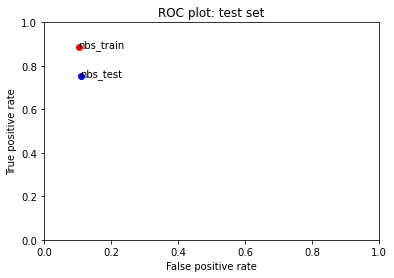

In [32]:
fits = [nbs_performance_train]

#svc_performance_train, -- Discussion Week 3
#rdg_performance_train, rdf_performance_train, 

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'ro')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
    


fits = [nbs_performance_test]

#svc_performance_testc0_0001  --  Discussion Week 3
#svm_performance_test, lgs_performance_test, , prc_performance_test, rdg_performance_test, rdf_performance_test, 
for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

---

# <span style="color:red">SUBMISSION</span>

---

In [26]:
# read in test data for submission
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
raw_data, X_test_submission = process_raw_data(fn='C:/Users/Dallas/Desktop/Machine Learning/toxiccomments_test.csv', my_random_seed=85, test=True)
print("Number of rows in the submission test set (should be 153,164): ")

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 153164 rows and 2 columns 

the data types for each of the columns in toxic_data:
id              object
comment_text    object
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text
0  00001cee341fdb12  Yo bitch Ja Rule is more succesful then you'll...
1  0000247867823ef7  == From RfC == \n\n The title is fine as it is...
2  00013b17ad220c46  " \n\n == Sources == \n\n * Zawe Ashton on Lap...
3  00017563c3f7919a  :If you have a look back at the source, the in...
4  00017695ad8997eb          I don't anonymously edit articles at all.
Shape of HashingVectorizer X:
(153164, 32768)
Look at a few rows of the new quantitative features: 
   word_count  punc_count  punc_count2  upper_case
0          72          10            0           4
1          13           1            0           7
2          16           0            0           4
3          38           3

---

Choose a <span style="color:red">*single*</span> model for your submission. In this code, I am choosing the Ordinary Least Squares model fit, which is in the `ols` object. But you should choose the model that is performing the best for you! 

In [27]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
my_submission["prediction"] = nbs.predict(X_test_submission)
# look at the proportion of positive predictions
print(my_submission['prediction'].mean())

0.2540153038573033


In [28]:
raw_data.head()

,id,comment_text,word_count,punc_count,punc_count2,upper_case
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,72,10,0,4
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,13,1,0,7
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",16,0,0,4
3,00017563c3f7919a,":If you have a look back at the source, the in...",38,3,0,4
4,00017695ad8997eb,I don't anonymously edit articles at all.,7,1,0,1


In [29]:
my_submission.head()

,id,prediction
0,00001cee341fdb12,True
1,0000247867823ef7,False
2,00013b17ad220c46,False
3,00017563c3f7919a,False
4,00017695ad8997eb,True


In [30]:
my_submission.shape

(153164, 2)

In [31]:
# export submission file as pdf
# CHANGE FILE PATH: 
my_submission.to_csv('C:/Users/Dallas/Desktop/Machine Learning/dataSubmission/toxiccomments_submission.csv', index=False)

# Submit to Canvas: 1) the CSV file that was written in the previous cell and 2) the url to the repository (GitHub or other) that contains your code and documentation